# Quantum Convolutional Neural Network (QCNN) for Sine Function Approximation

This notebook demonstrates the use of a Quantum Convolutional Neural Network (QCNN) to approximate the sine function. We will use the PennyLane library to implement the quantum circuit and optimize its parameters using a classical optimizer.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## Data Preparation
We discretize the interval $[0, 2\pi]$ to create input data points for the sine function.

In [2]:
n_qubits = 4
n_layers = int(np.log2(n_qubits))

num_points = 100
x = np.linspace(0, 2*np.pi, num_points)
y = np.sin(x)

## Quantum Circuit Design

We define the quantum convolutional and pooling layers. These layers are essential components of our QCNN. We construct the QCNN circuit using the defined layers and embed the input data using angle embedding. In this implementation, we utilize circular nearest neighbor interactions for the convolution and pooling layers, as discussed in [1].

In [3]:
def circular_nearest_neighbor(wires):
    edges = []
    seen = set()
    for i in range(len(wires)):
        a, b = i, (i + 1) % len(wires)
        if (b, a) not in seen:
            edges.append((a, b))
            seen.add((a, b))
    return edges

def quantum_conv_layer(params, wires):
    for wire1, wire2 in circular_nearest_neighbor(wires):
        qml.RY(params[0], wires=wire1)
        qml.RY(params[1], wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

def quantum_pool_layer(params, wires):
    for wire1, wire2 in circular_nearest_neighbor(wires):
        qml.CRZ(params[0], wires=[wire1, wire2])
        qml.PauliX(wires=wire1)
        qml.CRX(params[1], wires=[wire1, wire2])
        qml.PauliX(wires=wire1)

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qcnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    
    weight_idx = 0
    for layer in reversed(range(n_layers)):
        n_active = 2 ** (layer + 1)
        active_wires = list(range(n_qubits - n_active, n_qubits))
        
        quantum_conv_layer(weights[weight_idx:weight_idx+2], wires=active_wires)
        weight_idx += 2
        qml.Barrier(wires=range(n_qubits))
        
        quantum_pool_layer(weights[weight_idx:weight_idx+2], wires=active_wires)
        weight_idx += 2
        qml.Barrier(wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

## Training the QCNN

Training the Quantum Convolutional Neural Network (QCNN) involves defining a cost function and optimizing the network's parameters to minimize this cost. The cost function plays a crucial role in guiding the optimization process.

### Cost Function

In this implementation, we use the Mean Squared Error (MSE) as the cost function. MSE is a common choice for regression tasks, where the goal is to approximate a continuous function. It is defined as the average of the squares of the differences between the predicted and actual values:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2
$$

where $ \hat{y}_i $ is the predicted value, $ y_i $ is the actual value, and $ n $ is the number of data points. MSE provides a measure of how well the QCNN's predictions match the true sine function values. By minimizing the MSE, we aim to improve the accuracy of the QCNN model.

### Optimization

We use the Adam optimizer, a popular choice for training neural networks due to its adaptive learning rate and efficient handling of sparse gradients. The optimizer iteratively updates the network's parameters to minimize the cost function.

### Early Stopping

To prevent overfitting, early stopping is implemented. This technique monitors the cost function's improvement over iterations and stops the training process if the improvement falls below a specified threshold for a set number of consecutive iterations. This helps ensure that the model generalizes well to unseen data.

By combining these techniques, we aim to effectively train the QCNN to approximate the sine function while maintaining generalization and computational efficiency.

In [4]:
num_weights = sum([2 * (2 ** (layer + 1)) for layer in range(n_layers)]) * 2
weights_init = np.random.uniform(low=-np.pi, high=np.pi, size=num_weights, requires_grad=True)

def cost(weights, x, y):
    predictions = [qcnn_circuit(np.array([x_i] * n_qubits), weights) for x_i in x]
    return np.mean((np.array(predictions) - y) ** 2)

In [5]:
opt = qml.AdamOptimizer(stepsize=0.01)

steps = 5000
weights = weights_init
prev_cost = float('inf')
patience = 10
patience_counter = 0
cost_history = []

for i in range(steps):
    weights = opt.step(lambda w: cost(w, x, y), weights)
    current_cost = cost(weights, x, y)
    cost_history.append(current_cost)
    
    if (i + 1) % 100 == 0:
        print(f"Step {i+1}, Cost: {current_cost:.3f}")
    
    # Check for early stopping
    if np.abs(current_cost - prev_cost) < 1e-10:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at step {i+1}")
            break
    else:
        patience_counter = 0
    
    prev_cost = current_cost

Step 100, Cost: 0.471
Step 200, Cost: 0.409
Step 300, Cost: 0.408
Step 400, Cost: 0.408
Step 500, Cost: 0.408
Step 600, Cost: 0.408
Step 700, Cost: 0.335
Step 800, Cost: 0.114
Step 900, Cost: 0.106
Step 1000, Cost: 0.105
Early stopping at step 1048


## Results

After training the Quantum Convolutional Neural Network (QCNN), we evaluate its performance in approximating the sine function. The results are analyzed through the cost history plot and the comparison between the model's predictions and the actual sine function.

### Model Performance

The QCNN successfully approximates the sine function, achieving a final mean squared error of approximately 0.105.

In [6]:
y_pred = [qcnn_circuit(np.array([x_i] * n_qubits), weights) for x_i in x]
print(f"Final Mean Squared Error: {np.mean((y - y_pred)**2):.3f}")

Final Mean Squared Error: 0.105


### Cost History

The cost function, measured as the Mean Squared Error (MSE), is tracked over the optimization steps. The following are key observations from the cost history:

- **Initial Steps**: At the beginning of the training process, the cost is relatively high, starting at 0.471 at step 100. This indicates that the model's initial predictions are not closely aligned with the actual sine values.
- **Progressive Reduction**: As training progresses, the cost decreases steadily. By step 700, the cost drops to 0.335, showing significant improvement in the model's accuracy.
- **Rapid Improvement**: A notable reduction occurs between steps 700 and 800, where the cost decreases from 0.335 to 0.114. This suggests that the optimizer effectively navigated the parameter space to find a region with better performance.
- **Convergence**: After step 800, the cost stabilizes around 0.105, indicating convergence. The early stopping mechanism is triggered at step 1048, as further improvements are minimal, preventing overfitting.

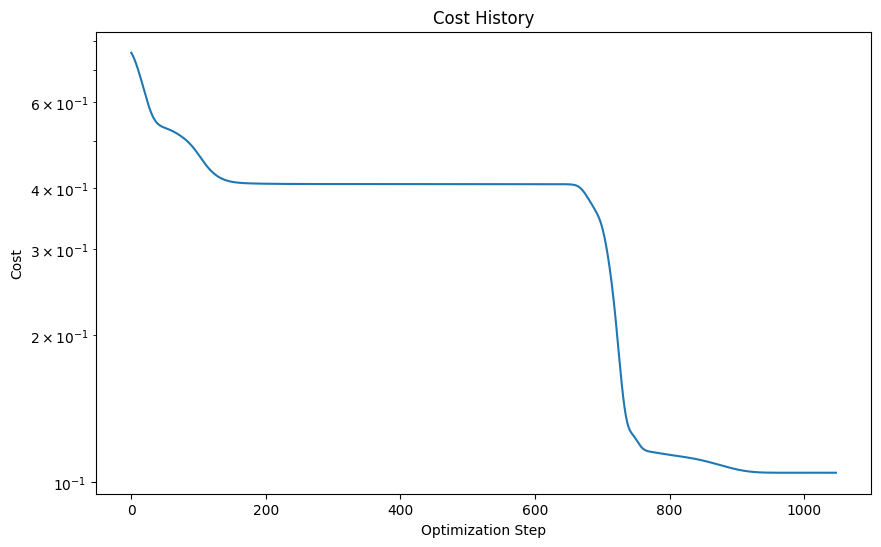

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Cost History')
plt.xlabel('Optimization Step')
plt.ylabel('Cost')
plt.yscale('log')
plt.show()

### Comparison of Sine Plots

Upon comparing the QCNN model's predictions with the actual sine function, we observe that while the overall shape and frequency of the sine wave are well-captured, there is a noticeable difference in amplitude. Specifically, the amplitude of the QCNN-generated sine wave is approximately half that of the actual sine function.

This amplitude discrepancy highlights areas for potential improvement, such as enhancing the quantum circuit's expressiveness or adjusting the data encoding strategy to better capture amplitude information.

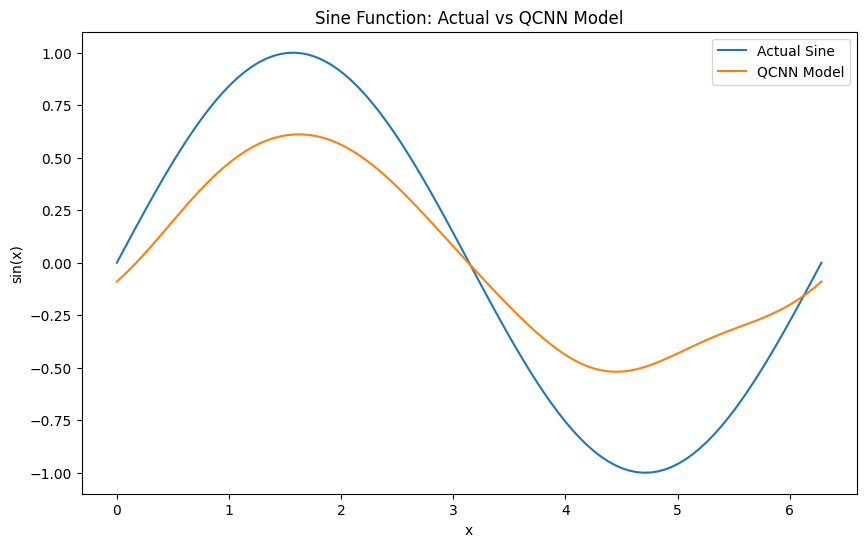

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Actual Sine')
plt.plot(x, y_pred, label='QCNN Model')
plt.legend()
plt.title('Sine Function: Actual vs QCNN Model')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.show()

## Conclusion

The implementation of a Quantum Convolutional Neural Network (QCNN) for approximating the sine function demonstrates the potential of quantum machine learning models in handling complex function approximation tasks. Despite the reduced amplitude observed in the QCNN's output, the model effectively captures the sine wave's frequency and shape, highlighting its capability to learn underlying patterns.

## References

[1] Cong, I., Choi, S., & Lukin, M. D. (2021). Quantum convolutional neural networks. *Quantum Machine Intelligence, 3*(1), 1-9. Retrieved from [https://link.springer.com/article/10.1007/s42484-021-00061-x](https://link.springer.com/article/10.1007/s42484-021-00061-x)